In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
import copy
import glob
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [9]:
### Esta seccion requiere configuracion por el usuario

# genera la lista de años y el arreglo de meses
years = [2021]          
meses = np.arange(4,5)

# informacion sobre el path de los archivos
readpath = 'D:\\CCA\\NASAGESDISC\\oco2lt\\STD\\oco2stdv10\\'
readformat = '.h5'
#readpath = 'D:\\CCA\\NASAGESDISC\\OCO3L2Lite\\LITE\\'
#readformat = '.nc4'

# use read_seedname si los nombres de la fuente tienen un formato establecido, de lo contrario use *
# NOTA: asegurese que el formato generado solo se repita en la seccion de fecha del archivo y no en otro identificador
# (e.g. orbita)
read_seedname = 'oco2_L2Std*_*_'
#read_seedname = 'oco3_LtCO2_'

# yearformat: 0 si es dos digitos, 1 si es 4 digitos

yearformat = 0

# nombre en el archivo HDF de las variables de latitud (y), longitud (x), y de interes (z)
latname = '/RetrievalGeometry/retrieval_latitude'
lonname = '/RetrievalGeometry/retrieval_longitude'
zname = '/RetrievalResults/xco2'
#latname = '/latitude'
#lonname = '/longitude'
#zname = '/xco2'

# qfexist: 0 si no hay variable de quality flag, 1 si hay variable de quality flag
qfexist = 0
qfname = '/xco2_quality_flag'

### Fin de seccion que requiere configuracion por el usuario

In [10]:
# contadores inevitables 
cont = 0

In [14]:
archivos = []
for year in years:
    for mes in meses:
        if yearformat == 1:
            filedate = read_seedname + '%i%02i*_*' % (year,mes)
        else:
            filedate = read_seedname + '%i%02i*_*' % (year-2000,mes)
        datapath = readpath + filedate + readformat
        lista = glob.glob(datapath)
        lista.sort()
        #print(lista)
        for ele in lista:
            archivos.append(ele)
        
print(len(archivos))
# end of testing

133


In [15]:
for archivo in archivos:
    data = h5py.File(archivo, 'r')
    
    if qfexist == 0:
        lat = np.expand_dims(data[latname],axis=1)
        lon = np.expand_dims(data[lonname],axis=1)
        zvar = np.expand_dims(data[zname],axis=1)
        
    if qfexist == 1:
        qf = data[qfname][()]
        print(qf)
        gridcond = (qf == 0)
        print(gridcond)
        lat_inter = data[latname][gridcond]
        lon_inter = data[lonname][gridcond]
        zvar_inter = data[zname][gridcond]
        
        lat = np.expand_dims(lat_inter,axis=1)
        lon = np.expand_dims(lon_inter,axis=1)
        zvar = np.expand_dims(zvar_inter,axis=1)
        
    # concatena los 4 vectores Nx1 en una matriz temporal Nx4
    mat=np.concatenate((lat,lon,zvar),axis=1)
    
    if cont == 0:
        # copia la matriz temporal en una permanente
        # esto solo se debe usar si no existe ya la matriz permanente
        datos=copy.copy(mat)
            
    else:
        # concatena los datos de la matriz temporal en la permanente
        # esto solo se debe usar si ya existe la matriz permanente
        datos=np.concatenate((mat,datos),axis=0)
                    
    cont = cont + 1
    data.close()
print(datos.shape)

(680548, 3)


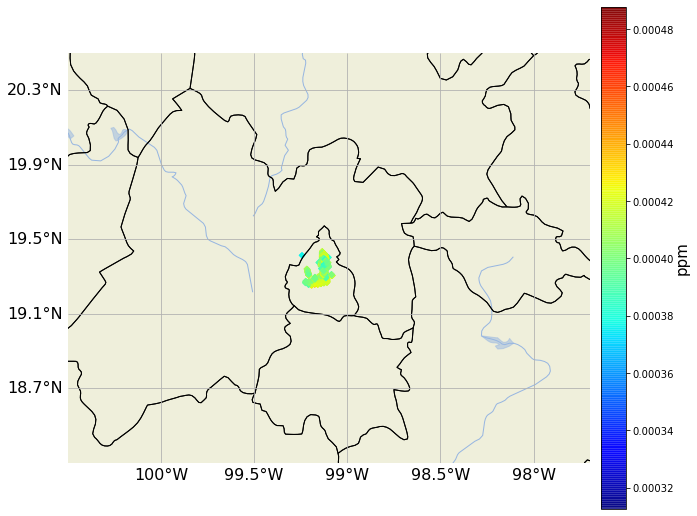

In [16]:
plt.figure(figsize=(10,10))

# Creates the map
mxmap = plt.axes(projection=ccrs.PlateCarree())

mxmap.add_feature(cfeature.LAND)
mxmap.add_feature(cfeature.OCEAN)
mxmap.add_feature(cfeature.COASTLINE)
mxmap.add_feature(cfeature.BORDERS, linestyle=':')
mxmap.add_feature(cfeature.LAKES, alpha=0.5)
mxmap.add_feature(cfeature.RIVERS)
mxmap.add_feature(cfeature.STATES.with_scale('10m'))
mxmap.set_extent((-100.5,-97.7,18.3,20.5))
mxmap.xaxis.set_visible(True)
mxmap.yaxis.set_visible(True)

#tickerx = np.arange(-99.5,-98.6,0.4)
tickery = np.arange(18.3,20.5,0.4)
glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#glines.xlocator = mticker.FixedLocator(tickerx)
glines.ylocator = mticker.FixedLocator(tickery)
glines.xformatter = LongitudeFormatter()
glines.yformatter = LatitudeFormatter()
glines.top_labels = None
glines.right_labels = None
#glines.left_labels = None
glines.xlabel_style = {'size': 16}
glines.ylabel_style = {'size': 16}

fig=plt.scatter(datos[:,1], datos[:,0], alpha=0.8, 
            s=15,c=datos[:,2], marker = 'D', 
            cmap=plt.get_cmap("jet"), 
            transform=ccrs.PlateCarree())
#plt.plot(-99.1761,19.3262,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-99.1661,19.3262, 'CCA',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-99.147,19.483781,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-99.137,19.483781, 'Vallejo',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-99.0203,19.4254,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-99.0103,19.4254, 'BOXO',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-99.198,19.722,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-99.188,19.722, 'Cuautitlan',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-98.967,19.733,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-98.957,19.733, 'Tecamac',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-98.833,19.11783,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-98.823,19.11783, 'Amecameca',horizontalalignment='left', transform=ccrs.Geodetic())
#plt.plot(-98.6552,19.1187,  markersize=10, marker='o', color='red',transform=ccrs.PlateCarree())
#plt.text(-98.6452,19.1187, 'Altzomoni',horizontalalignment='left', transform=ccrs.Geodetic())
plt.axis('off')
fig.axes.xaxis.set_visible(False)
fig.axes.yaxis.set_visible(False)
#plt.title("xCO2",size=15)
#plt.xlabel("Longitude",size=15)
#plt.ylabel("Latitude",size=15)
cbar= plt.colorbar(fraction=0.045, pad=.02)
cbar.set_label("ppm", size=15, labelpad=0.8)
#cbar.ax.tick_params(labelsize=12)
#plt.savefig('target_dist.png')
plt.show()

In [11]:
np.savetxt("datosOCO3Ltqf.csv", datos, delimiter=",")